In [322]:
#conda update --all
#%pip install gensim
#%pip install nltk
#%pip install termcolor
#%pip install wordcloud

#import nltk
#nltk.download('stopwords')

##  1. OPIS PROBLEMA
***

U ovoj bilježnici istraživat ćemo *natural language processing* (NLP) analizirajući 10000 tweetova podijeljenih u dvije kategorije. 
Tweetovi su grupirani s obzirom na one čija je tematika neka prirodna ili socijalna katastrofa i one koji to nisu. 

Prilikom analize koristit ćemo bazu podatka dostupnu na platformi *Kaggle* gdje je rješenje ovoga problema moguće podijeliti sa ostalim korisnicima platforme. Upravo je ondje tema i osmišljena pod nazivom **Natural Language Processing with Disaster Tweets**. Mnoge zanimljive i praktične metode rješavanja ovog zadatka dostupne su na *https://www.kaggle.com/c/nlp-getting-started*.

Kao primjer promotrimo sljedeće tweetove:

***
    TWEET 1:  That concert last night was FIRE!
    TWEET 2:  There's a huge forest fire in Malibu right now!!! 
***

Iako oba tweeta koriste riječ *fire* samo drugi uistinu govori o stvarnoj, u ovom slučaju prirodnoj, nepogodi, odnosno katastrofi.
Možemo li istrenirati model koji će znati razlikovati i pravilno klasificirati ove dvije vrste poruka? Pokušajmo saznati!


## 2.  EKSPLORATORNA ANALIZA PROBLEMA
***

### Podaci
***

Dodajemo sve biblioteke koje će nam trebati (možda treba pozvati %pip install za slučaj da na računalu nisu instalirane):

In [323]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop = set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from termcolor import colored
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import wordcloud
import csv

Skidanje podataka s našeg repozitorija na GitHub-u i njihovo lokalno spremanje:

In [324]:
def skini(url: str, datoteka: str):
    import urllib.request as rq, pathlib
    with rq.urlopen(url) as konekcija:
        pathlib.Path(datoteka).write_bytes(konekcija.read())
        
test_podaci = 'https://raw.githubusercontent.com/jbrigljevic/str_uc/main/Podaci/test.csv'
train_podaci = 'https://raw.githubusercontent.com/jbrigljevic/str_uc/main/Podaci/train.csv'
skini(test_podaci, 'test_podaci.csv')
skini(train_podaci, 'train_podaci.csv')

Učitavanje u Dataframe:

In [325]:
df_test = pd.read_csv('test_podaci.csv')
df_train = pd.read_csv('train_podaci.csv')

**Promotrimo oblik i formu učitanih podataka za treniranje pa zatim podataka za testiranje na nekoliko konkretnih primjera:**

In [326]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [327]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [328]:
print(colored('\nU tablici podataka za treniranje nalazi se {} redaka i {} stupaca.'.format(df_train.shape[0], df_train.shape[1]), 'red', attrs = ['bold']))
print(colored('U tablici podataka za testiranje nalaze se {} retka i {} stupca.'.format(df_test.shape[0], df_test.shape[1]), 'red', attrs = ['bold']))


U tablici podataka za treniranje nalazi se 7613 redaka i 5 stupaca.
U tablici podataka za testiranje nalaze se 3263 retka i 4 stupca.


***
Zaključujemo da spremljeni podaci imaju tri svojstva podložna detaljnijoj analizi: ***keyword, location*** i ***text***.

Spremit ćemo ID retka za krajnju analizu te integrirati dane podatke u jedinstveni DataFrame. Međutim, prije nego što to učinimo promotrimo koja bi od navedenih svojstava bilo uistinu korisno zadržati u novonastalom DataFrame-u. 
***

Za početak promatramo koliko podataka iz skupa za treniranje, a koliko iz testnog skupa nema zadano svojstvo *location*:

In [329]:
print(colored(df_train['location'].isnull().value_counts(), 'green'));

False    5080
True     2533
Name: location, dtype: int64


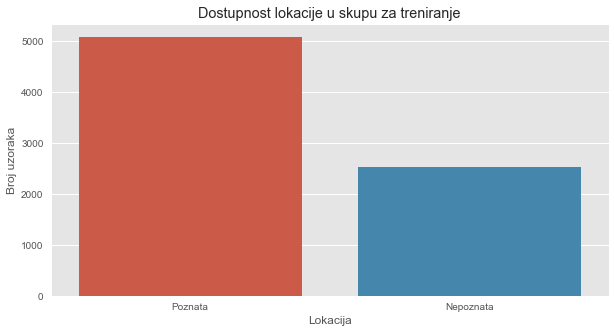

In [330]:
fig, ax = plt.subplots(figsize = (10, 5))

graph = sns.countplot(x = df_train['location'].isnull().index, data = df_train['location'].isnull())

graph.set(xticklabels = ['Poznata', 'Nepoznata'])
plt.gca().set_ylabel('Broj uzoraka')
plt.gca().set_xlabel('Lokacija')
plt.title('Dostupnost lokacije u skupu za treniranje')

plt.show(graph)

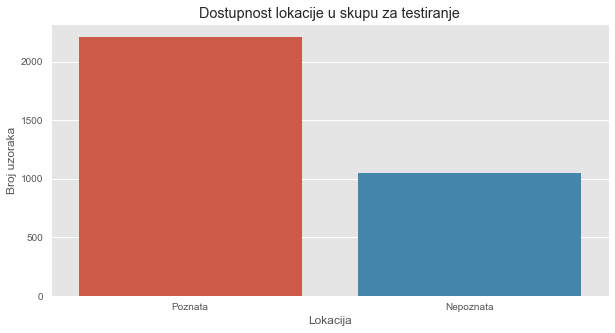

In [331]:
fig, ax = plt.subplots(figsize = (10, 5))

graph = sns.countplot(x = df_test['location'].isnull().index, data = df_train['location'].isnull())

graph.set(xticklabels = ['Poznata', 'Nepoznata'])
plt.gca().set_ylabel('Broj uzoraka')
plt.gca().set_xlabel('Lokacija')
plt.title('Dostupnost lokacije u skupu za testiranje')

plt.show(graph)

**Zaključujemo da u treniranju modela nema smisla promatrati svojstvo *location* budući da je kod prevelikog udjela danih podataka to svojstvo nepoznato.** Stoga pri integriranju testnih podataka i onih za treniranje modela, izostavljamo informaciju o lokaciji tweeta. 

Nastavimo našu analizu promatranjem dostupnosti svojstva keyword:

In [332]:
print(colored(df_train['keyword'].isnull().value_counts(), 'green'));

False    7552
True       61
Name: keyword, dtype: int64


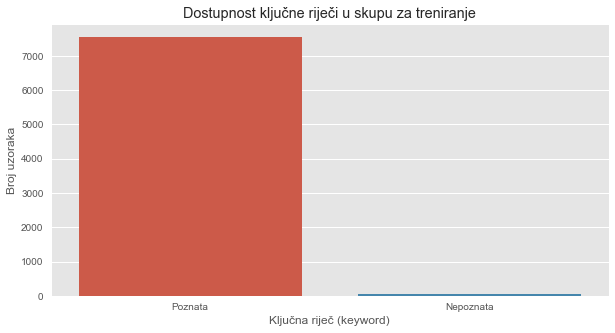

In [333]:
fig, ax = plt.subplots(figsize = (10, 5))

graph = sns.countplot(x = df_train['keyword'].isnull().index, data = df_train['keyword'].isnull())

graph.set(xticklabels = ['Poznata', 'Nepoznata'])
plt.gca().set_ylabel('Broj uzoraka')
plt.gca().set_xlabel('Ključna riječ (keyword)')
plt.title('Dostupnost ključne riječi u skupu za treniranje')

plt.show(graph)

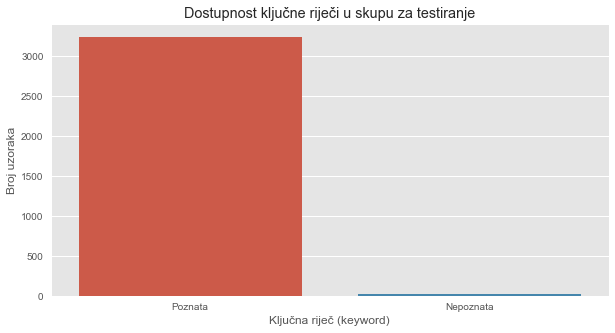

In [334]:
fig, ax = plt.subplots(figsize = (10, 5))

graph = sns.countplot(x = df_test['keyword'].isnull().index, data = df_test['keyword'].isnull())

graph.set(xticklabels = ['Poznata', 'Nepoznata'])
plt.gca().set_ylabel('Broj uzoraka')
plt.gca().set_xlabel('Ključna riječ (keyword)')
plt.title('Dostupnost ključne riječi u skupu za testiranje')

plt.show(graph)

Dolazimo do saznanja da je ključna riječ, odnosno svojstvo *keyword*, poznato u gotovo svim uzorcima pa ćemo ga uključiti i u naše integrirane podatke. Spremimo ključne riječi u skupove *skup_keyword_test* i *skup_keyword_train* koje ćemo koristiti pri detaljnijoj analizi ovog svojstva u dostupnim podacima.

In [335]:
skup_keyword_test = {keyword for keyword in df_test['keyword']}
skup_keyword_train = {keyword for keyword in df_train['keyword']}

Započnimo sada s već prije spomenutim spajanjem podataka.

In [336]:
#spremamo ID
test_id = df_test['id']

#dropamo lokaciju i id iz train i test data framea
columns = {'id', 'location'}
df_train = df_train.drop(columns = columns)
df_test = df_test.drop(columns = columns)

#popunimo nepoznate keywords s 'unknown'
df_train['keyword'] = df_train['keyword'].fillna('unknown')
df_test['keyword'] = df_test['keyword'].fillna('unknown')

#stvaramo strukture potrebne za kasniju analizu podataka na osnovu kljucne rijeci
df_keyword_train = df_train;
df_keyword_test = df_test;

#dodajemo keyword u tekst tweeta
df_train['text'] = df_train['text'] + ' ' + df_train['keyword']
df_test['text'] = df_test['text'] + ' ' + df_test['keyword']

#dropamo keyword iz df_train i df_test
columns = {'keyword'}
df_train = df_train.drop(columns = columns)
df_test = df_test.drop(columns = columns)

#spojimo podatke u jedan data frame
df_total = pd.concat([df_train, df_test])

print(colored('\nU novonastalom data frameu pod nazivom df_total nalazi se {} zapisa, odnosno tweetova organiziranih na sljedeći način: '.format(df_total.shape[0]), 'red', attrs = ['bold']))
df_total.head()


U novonastalom data frameu pod nazivom df_total nalazi se 10876 zapisa, odnosno tweetova organiziranih na sljedeći način: 


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1.0
1,Forest fire near La Ronge Sask. Canada unknown,1.0
2,All residents asked to 'shelter in place' are ...,1.0
3,"13,000 people receive #wildfires evacuation or...",1.0
4,Just got sent this photo from Ruby #Alaska as ...,1.0



Prije nego započnemo s detaljnijom analizom podataka, promotrimo distribuciju podataka za treniranje u klase *Katastrofa* i *Nije katastrofa*.

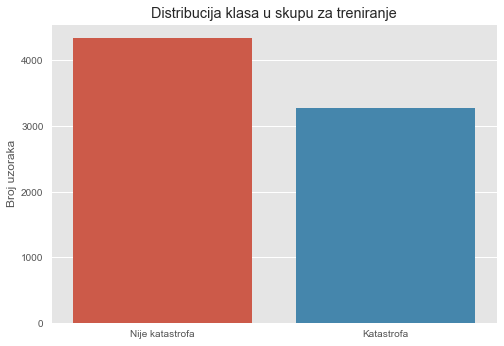

In [337]:
x = df_train.target.value_counts()
sns.barplot(x = x.index, y = x)

plt.gca().set_ylabel('Broj uzoraka');
plt.title('Distribucija klasa u skupu za treniranje');
plt.gca().set(xticklabels = ['Nije katastrofa', 'Katastrofa']);

Zaključujemo da je u našem skupu za treniranje više tweetova koji ne govore o pravoj katastrofi, nego onih koji opisuju stvarnu tragičnu ili opasnu situaciju.
***

### Dodavanje osnovnih svojstava
***

Radi jednostavnije analize obilježja i strukture tweetova koji govore o katastrofama, novonastalom skupu podataka dodajemo nova, zanimljiva i praktična svojstva. 

In [338]:
#stvaramo stupac za broj riječi u pojedinom tweetu
df_total['word count'] = df_total['text'].apply(lambda x: len(x.split()))

#sliceamo da bismo ažurirali train set
df_train = df_total[:len(df_train)]

df_train.head()

,text,target,word count
0,Our Deeds are the Reason of this #earthquake M...,1.0,14
1,Forest fire near La Ronge Sask. Canada unknown,1.0,8
2,All residents asked to 'shelter in place' are ...,1.0,23
3,"13,000 people receive #wildfires evacuation or...",1.0,9
4,Just got sent this photo from Ruby #Alaska as ...,1.0,17


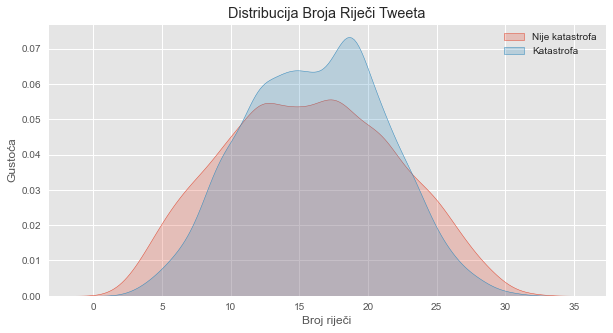

In [339]:
#definiramo subplot da bismo grafove smjestili jedan do drugoga
fig, ax = plt.subplots(figsize = ( 10, 5))

#kreiramo grafove
sns.kdeplot(df_train['word count'][df_train['target'] == 0], shade = True, label = 'Nije katastrofa', legend = True)
sns.kdeplot(df_train['word count'][df_train['target'] == 1], shade = True, label = 'Katastrofa', legend = True)

#naslov grafa
plt.title('Distribucija Broja Riječi Tweeta')
plt.gca().set_ylabel('Gustoća')
plt.gca().set_xlabel('Broj riječi')

plt.legend()
plt.show()

Slijede skupovi ključnih riječi i lokacija te mapa s textovima samih tweetova i pripadajuće oznake.

In [340]:
#stvori stupac za broj znakova u tweetu
df_total['character count'] = df_total['text'].apply(lambda x: len(x))

#sliceamo da bismo ažurirali train set 
df_train = df_total[:len(df_train)]

df_train.head()

,text,target,word count,character count
0,Our Deeds are the Reason of this #earthquake M...,1.0,14,77
1,Forest fire near La Ronge Sask. Canada unknown,1.0,8,46
2,All residents asked to 'shelter in place' are ...,1.0,23,141
3,"13,000 people receive #wildfires evacuation or...",1.0,9,73
4,Just got sent this photo from Ruby #Alaska as ...,1.0,17,96


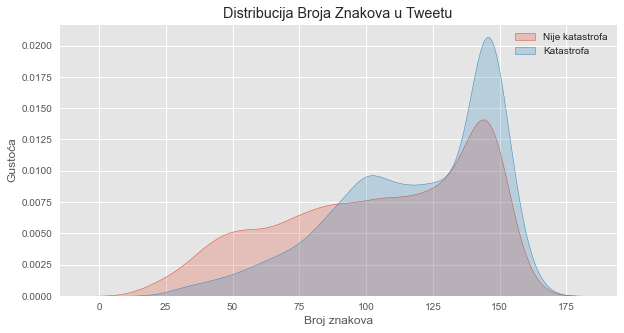

In [341]:
#definiramo subplot da bismo grafove vidjeli skupa
fig, ax = plt.subplots(figsize = (10, 5))

#kreiramo grafove
sns.kdeplot(df_train['character count'][df_train['target'] == 0], shade = True, label = 'Nije katastrofa')
sns.kdeplot(df_train['character count'][df_train['target'] == 1], shade = True, label = 'Katastrofa')

#naslov grafa
plt.title('Distribucija Broja Znakova u Tweetu')
plt.gca().set_ylabel('Gustoća')
plt.gca().set_xlabel('Broj znakova')

plt.legend()
plt.show()

**Promatrajući dobiveni graf zaključujemo da tek mali broj tweetova o stvarnoj katastrofi sadrži manje od 50 znakova, dok većina sadrži više od 125 znakova.**

In [342]:
#definiramo funkciju za pronalazak prosjecne duljine rijeci
def prosjecna_duljina_rijeci(x):
    x = x.split()
    return np.mean([len(i) for i in x])

#primjenjujemo funkciju na stupac 'text'
df_total['average word length'] = df_total['text'].apply(prosjecna_duljina_rijeci)

#sliceamo da bismo ažurirali train set
df_train = df_total[:len(df_train)]

df_train.head()

,text,target,word count,character count,average word length
0,Our Deeds are the Reason of this #earthquake M...,1.0,14,77,4.571429
1,Forest fire near La Ronge Sask. Canada unknown,1.0,8,46,4.875000
2,All residents asked to 'shelter in place' are ...,1.0,23,141,5.173913
3,"13,000 people receive #wildfires evacuation or...",1.0,9,73,7.111111
4,Just got sent this photo from Ruby #Alaska as ...,1.0,17,96,4.647059


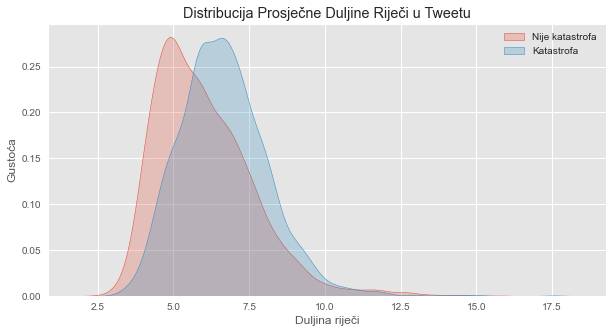

In [343]:
#definiramo subplot da bismo grafove vidjeli skupa
fig, ax = plt.subplots(figsize = (10, 5))

#kreiramo graf
sns.kdeplot(df_train['average word length'][df_train['target'] == 0], shade = True, label = 'Nije katastrofa')
sns.kdeplot(df_train['average word length'][df_train['target'] == 1], shade = True, label = 'Katastrofa')

#naslov grafa
plt.title('Distribucija Prosječne Duljine Riječi u Tweetu')
plt.gca().set_ylabel('Gustoća')
plt.gca().set_xlabel('Duljina riječi')

plt.legend()
plt.show()

In [344]:
#broj jedinstvenih riječi
df_total['unique word count'] = df_total['text'].apply(lambda x: len(set(x.split())))

#brojimo stopwords odnosno riječi koje znatno ne prinose značenju rečenice
df_total['stopword count'] = df_total['text'].apply(lambda x: len([i for i in x.lower().split() if i in wordcloud.STOPWORDS]))

#omjer stopwords/total words
df_total['stopword ratio'] = df_total['stopword count'] / df_total['word count']

#brojimo interpunkcije
df_total['punctuation count'] = df_total['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

#sliceamo da bismo ažurirali train set
df_train = df_total[:len(df_train)]

df_train.head()

,text,target,word count,character count,average word length,unique word count,stopword count,stopword ratio,punctuation count
0,Our Deeds are the Reason of this #earthquake M...,1.0,14,77,4.571429,14,6,0.428571,1
1,Forest fire near La Ronge Sask. Canada unknown,1.0,8,46,4.875000,8,0,0.000000,1
2,All residents asked to 'shelter in place' are ...,1.0,23,141,5.173913,21,11,0.478261,3
3,"13,000 people receive #wildfires evacuation or...",1.0,9,73,7.111111,9,1,0.111111,2
4,Just got sent this photo from Ruby #Alaska as ...,1.0,17,96,4.647059,16,7,0.411765,2


Kreirajmo sada grafove distribucije prethodno definiranih svojstava.

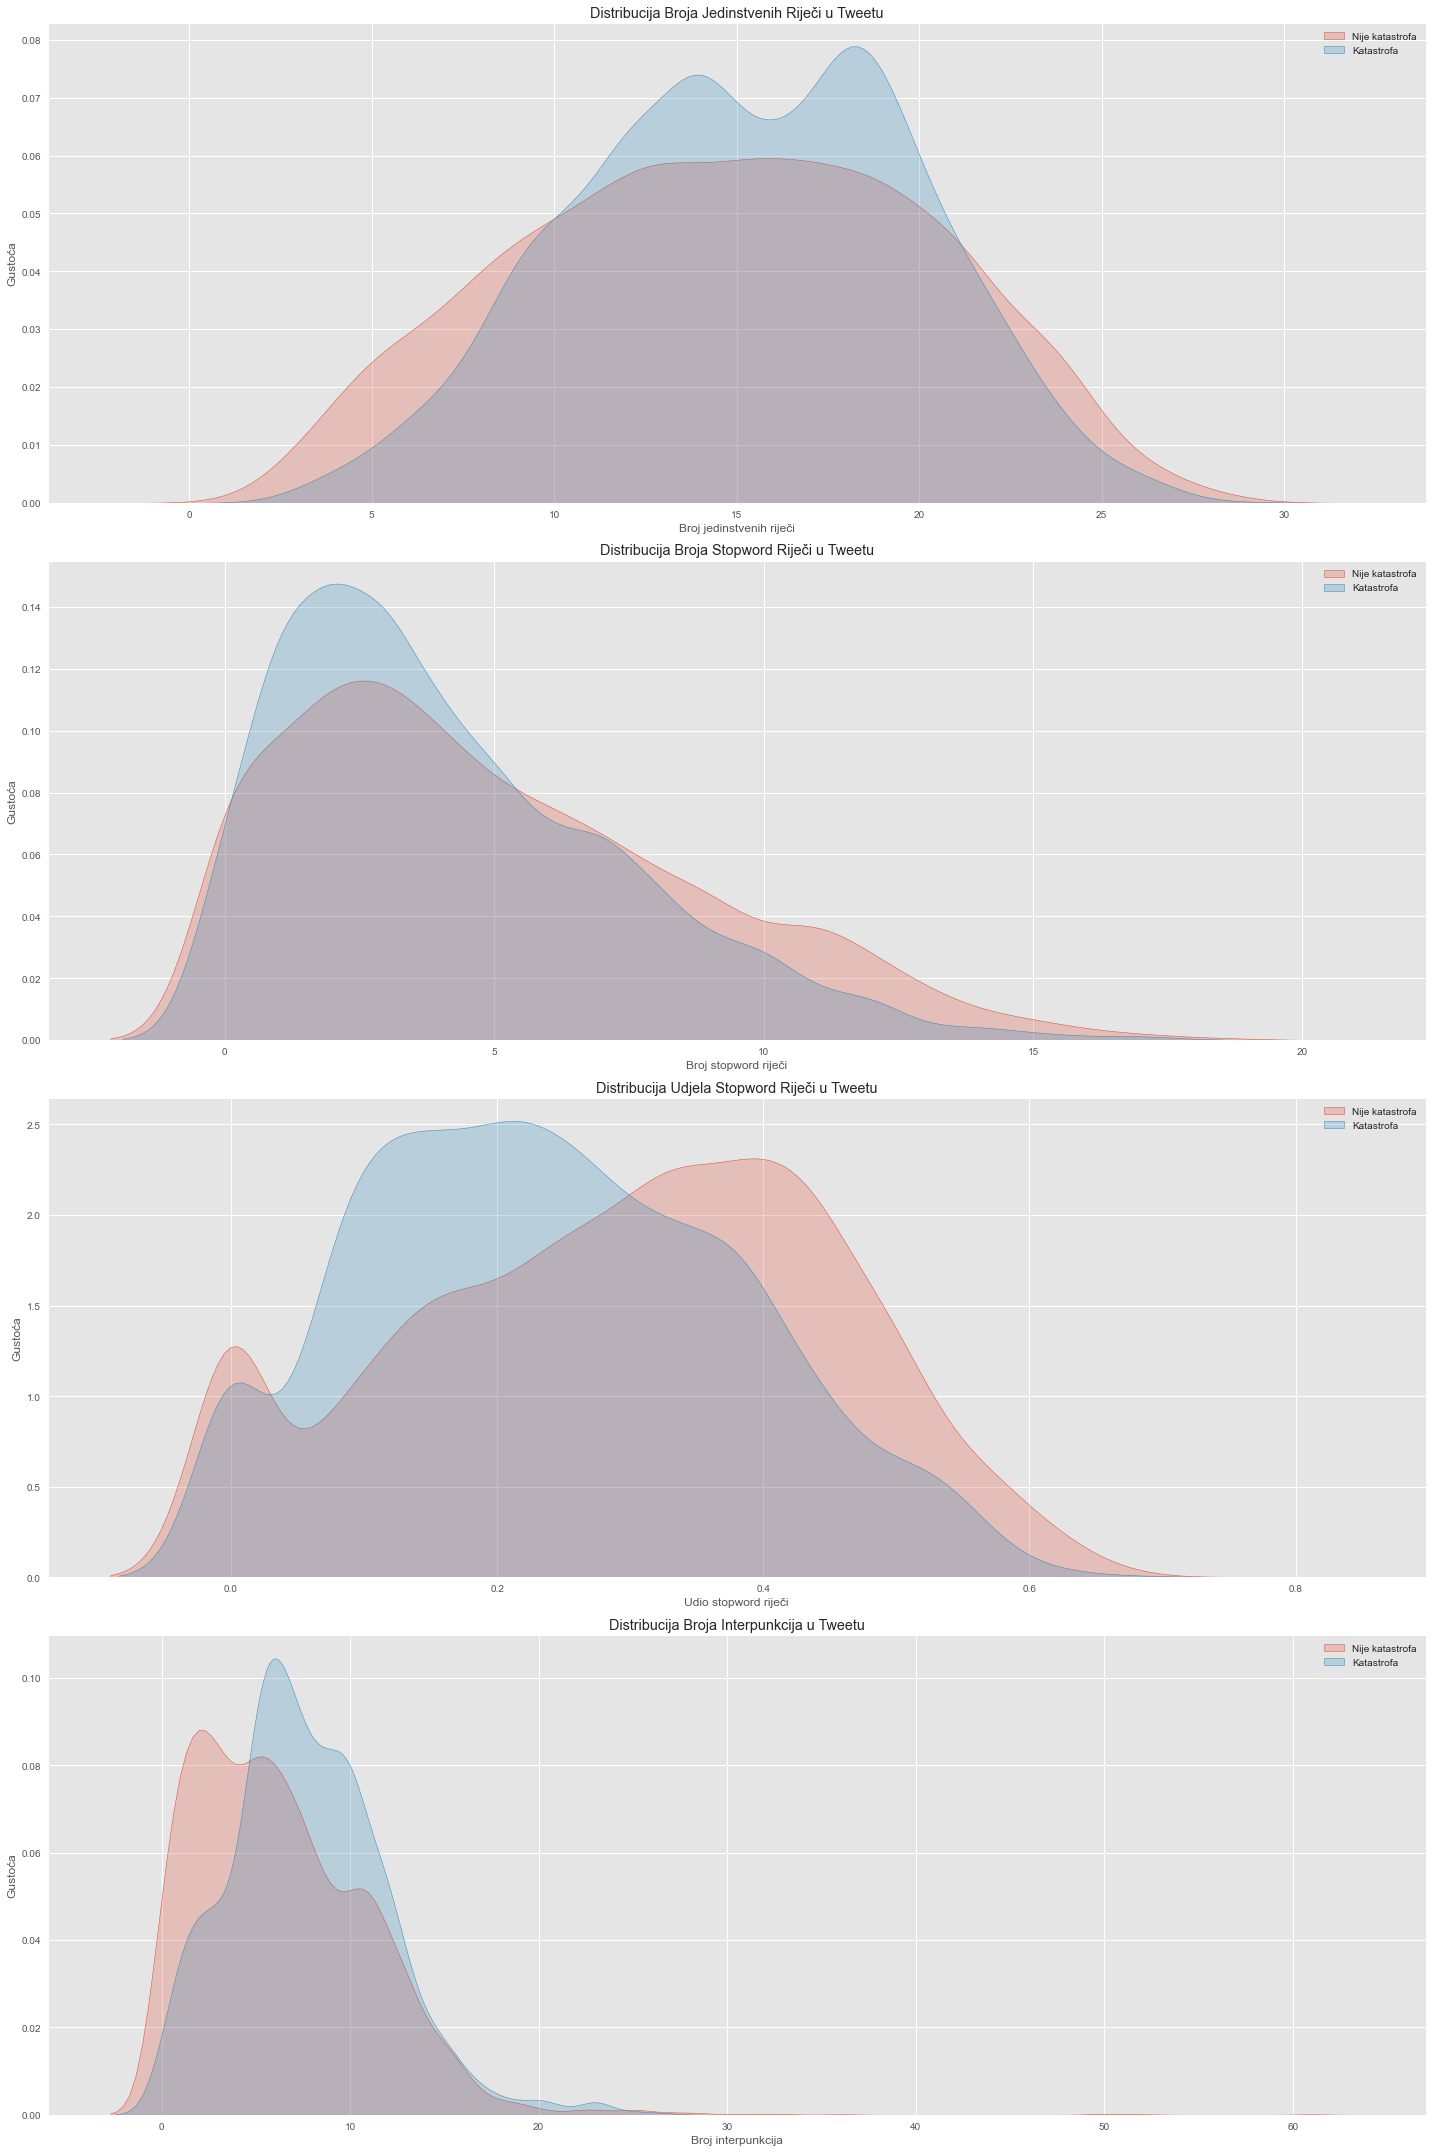

In [345]:
katastrofe = df_train['target'] == 1

fig, axes = plt.subplots(4, figsize = (20, 30))

#broj jedinstvenih rijeci
graph1 = sns.kdeplot(df_train.loc[~katastrofe]['unique word count'], shade = True, label = 'Nije katastrofa', ax = axes[0])
graph1 = sns.kdeplot(df_train.loc[katastrofe]['unique word count'], shade = True, label = 'Katastrofa', ax = axes[0])
graph1.set_title('Distribucija Broja Jedinstvenih Riječi u Tweetu')
graph1.set_ylabel('Gustoća')
graph1.set_xlabel('Broj jedinstvenih riječi')
graph1.legend()


#stopword count
graph2 = sns.kdeplot(df_train.loc[~katastrofe]['stopword count'], shade = True, label = 'Nije katastrofa', ax = axes[1])
graph2 = sns.kdeplot(df_train.loc[katastrofe]['stopword count'], shade = True, label = 'Katastrofa', ax = axes[1])
graph2.set_title('Distribucija Broja Stopword Riječi u Tweetu')
graph2.set_ylabel('Gustoća')
graph2.set_xlabel('Broj stopword riječi')
graph2.legend()

#stopword omjer
graph3 = sns.kdeplot(df_train.loc[~katastrofe]['stopword ratio'], shade = True, label = 'Nije katastrofa', ax = axes[2])
graph3 = sns.kdeplot(df_train.loc[katastrofe]['stopword ratio'], shade = True, label = 'Katastrofa', ax = axes[2])
graph3.set_title('Distribucija Udjela Stopword Riječi u Tweetu')
graph3.set_ylabel('Gustoća')
graph3.set_xlabel('Udio stopword riječi')
graph3.legend()

#broj interpunkcijskih znakova
graph4 = sns.kdeplot(df_train.loc[~katastrofe]['punctuation count'], shade = True, label = 'Nije katastrofa', ax = axes[3])
graph4 = sns.kdeplot(df_train.loc[katastrofe]['punctuation count'], shade = True, label = 'Katastrofa', ax = axes[3])
graph4.set_title('Distribucija Broja Interpunkcija u Tweetu')
graph4.set_ylabel('Gustoća')
graph4.set_xlabel('Broj interpunkcija')
graph4.legend()

fig.tight_layout()
plt.show()

Promatrajući grafove možemo naslutiti da će tweetovi koji govore o stvarnoj katastrofi sadržavati manji broj i udio *stopword* riječi, odnosno riječi koje svojim sadržajem ne pridonose znatno značenju rečenice, odnosno tweeta. Također, takvi će tweetovi sadržavati više interpunkcijskih znakova, što bismo intuitivno mogli i pretpostaviti, budući da se pri razmjenjivanju šokantnih vijesti i poruka obilno te višestruko koriste interpunkcije poput *!* i *?*.

Započnimo sada analizu podataka s obzirom na ključnu riječ koji sadrže.

### Ključna riječ
---

Koristit ćemo prije definirane *df_keyword_train* i *df_keyword_test* pa za početak promotrimo njihovu formu, odnosno strukturu:

In [346]:
df_keyword_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   keyword  7613 non-null   object
 1   text     7613 non-null   object
 2   target   7613 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 178.6+ KB


In [347]:
df_keyword_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   keyword  3263 non-null   object
 1   text     3263 non-null   object
dtypes: object(2)
memory usage: 51.1+ KB


Pogledajmo sada frekvencije ključnih riječi koje se spominju u danim podacima:

In [348]:
def graf_br_kljucnih(df):
    count_keyword_positive = {}
    count_keyword_negative = {}
    for keyword in df['keyword'].unique():
        if(not pd.isna(keyword)):
            if(keyword in df[df['target'] == 1]['keyword'].unique()):
                count_keyword_positive[keyword] = df[df['target'] == 1]['keyword'].value_counts()[keyword]
            else:
                count_keyword_positive[keyword] = 0
                
            if(keyword in df[df['target'] == 0]['keyword'].unique()):
                count_keyword_negative[keyword] = df[df['target'] == 0]['keyword'].value_counts()[keyword]
            else:
                count_keyword_negative[keyword] = 0
            
    count_keyword_positive = {k: v for k, v in sorted(count_keyword_positive.items(), key=lambda item: item[1])}

    count_keyword_negative_sorted = {}
    for keyword in count_keyword_positive:
        count_keyword_negative_sorted[keyword] = count_keyword_negative[keyword]
    
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(figsize = (12, 200))
    b1 = ax.barh(list(count_keyword_positive.keys()), list(count_keyword_positive.values()), color = 'cornflowerblue')
    b2 = ax.barh(list(count_keyword_negative_sorted.keys()), list(count_keyword_negative_sorted.values()),
            left = list(count_keyword_positive.values()), color = 'indianred')
    
    for index, value in enumerate(list(count_keyword_positive.values())):
        if(value > 2):
            plt.text(value, index, str(value) + ' / ' + str(list(count_keyword_negative_sorted.values())[index]),
                 ha = 'right', va = 'center')
            
        elif(value == 2):
            plt.text(value + 1, index, str(value) + ' / ' + str(list(count_keyword_negative_sorted.values())[index]),
                 ha = 'right', va = 'center')
            
        elif(value == 1):
            plt.text(value + 2.5, index, str(value) + ' / ' + str(list(count_keyword_negative_sorted.values())[index]),
                 ha = 'right', va = 'center')
            
        else:
            plt.text(value + 3, index, str(value) + ' / ' + str(list(count_keyword_negative_sorted.values())[index]),
                 ha = 'right', va = 'center')
    
    plt.legend([b1, b2], ['Pozitivni', 'Negativni'], title = 'Oznaka', loc = 'upper right')
    plt.title('Broj ključnih riječi ovisno o oznaci')
    plt.margins(y=0.001)
    plt.show()

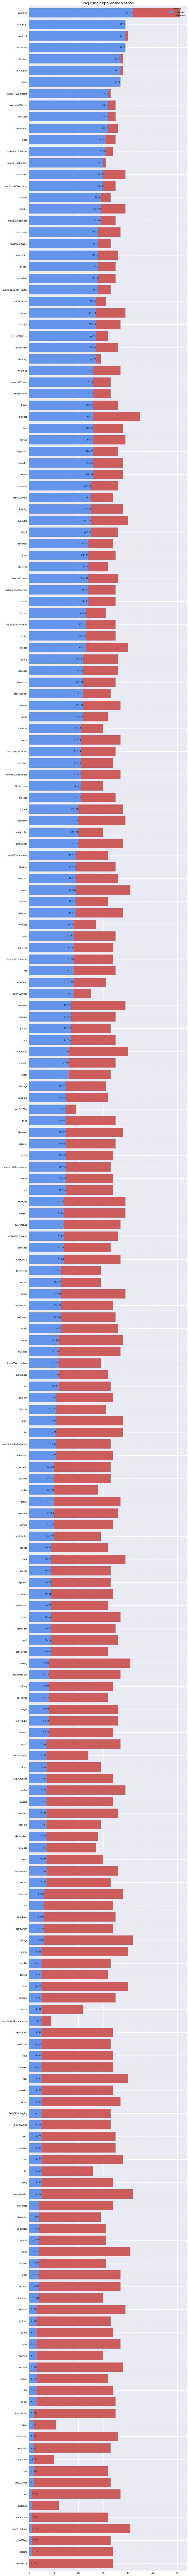

In [349]:
graf_br_kljucnih(df_keyword_train)

Ono što možemo uočiti jest da određene riječi u potpunosti, a velik dio njih u većoj mjeri, određuju oznaku primjeraka.

## 3.  ČIŠĆENJE PODATAKA
***

Promatrajući ogromnu količinu riječi sadržanih u danim podacima, prirodno se nameće pitanje jesu li uistinu sve riječi u pojedinom tweetu jednako važne pri njegovoj klasifikaciji u jednu od ponuđenih skupina. Također, uzimajući u obzir način i mjesto sakupljanja podataka, kao i njihovu strukturu, lako je primijetiti da u samome tekstu svakoga tweet-a mogu postojati nizovi znakova bez semantičkog značenja, kao što su linkovi ili pak emoji naljepnice. Naposlijetku, budući da korisnici objave na društvenim mrežama nerijetko pišu bez obraćanja prevelike pozornosti na razne pravopisne pogreške, moguće je da u danome skupu imamo veliku količinu neispravno napisanih riječi. 

Zaključujemo dakle da je prije konstrukcije bilo kakvog modela, potrebno napraviti temeljito čiščenje podataka koje će tekst pripremiti za efkasno provođenje metoda strojnog učenja. Prije provođenja opisanih postupaka promotrimo još jednom strukturu teksta sadržanog u skupu podataka za treniranje na nekoliko primjera:

In [350]:
# Mičemo interpunkcijske znakove
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

# Pomoćna funkcija
def seperate_string_number(string):
    previous_character = string[0]
    groups = []
    newword = string[0]
    for x, i in enumerate(string[1:]):
        if i.isalpha() and previous_character.isalpha():
            newword += i
        elif i.isnumeric() and previous_character.isnumeric():
            newword += i
        else:
            groups.append(newword)
            newword = i

        previous_character = i

        if x == len(string) - 2:
            groups.append(newword)
            newword = ''
    return groups

# Mičemo riječi koje sadrže znakove izvan abecede, s tim da razdvajamo one koje sadrže brojeve
def remove_non_alphabet(x):
    string = ""
    for i in x.split():
        tmp = seperate_string_number(i)
        string = string + " " + " ".join(tmp)
    return string

# Mičemo stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

# Mičemo riječi s manje od 3 znaka
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 2])

def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

Promotrimo djelovanje funkcije <b>strip_all_entities</b> definirane na samome kraju prethodne ćelije:

In [351]:
#check strip_all_entities functionality
strip_all_entities('@lukamodric10 A very special match tonight against @equipedefrance #GoCroatia #podbjeda 🏆 https://youtu.be/le54R3QYT7U !! ')

'A very special match tonight against GoCroatia podbjeda'


Zaključujemo da će nam ova funkcija omogućiti uklanjanje semantički nebitnih informacija iz ulaznih podataka, kao što su poveznice na razne internet stranice, imena drugih Twitter korisnika, emoji naljepnice te izvlačenje sadržaja iz, na društvenim mrežama često korištenih i popularnih, hashtagova.

Također, moguće je ispraviti podatke s manjm pravopisnim pogreškama. Iako je ovo računarski veoma skupa operacija, procjenjujemo da je na ovakvom skupu podataka više nego dobrodošla, budući da tekst prilikom objavljivanja na Twitter ne prolazi kroz nikakvu pravopisnu provjeru.  

In [352]:
#instaliramo autocorrect
!pip install autocorrect 
from autocorrect import Speller

# stvaramo funkciju za provjeru pravopisa danog stringa
def spell_check(x):
    spell = Speller(lang = 'en')
    return " ".join([spell(i) for i in x.split()])

Promotrimo sada kako radi upravo definirana funkcija <b>spell_check</b>:

In [353]:
misspelled = 'I olways had a veri good grade in englis, expecialy gramar'
spell_check(misspelled)

'I always had a very good grade in english, especially grammar'

Sada ćemo definirane funkcije primijeniti na ulazne podatke:

In [354]:
%%time
SPELL_CHECK = True
    
# primjenjujemo sve do sada definirane funkcije
df_total['text'] = df_total['text'].apply(lambda x: x.lower())
df_total['text'] = df_total['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
df_total['text'] = df_total['text'].apply(remove_punctuation)
df_total['text'] = df_total['text'].apply(remove_non_alphabet)
df_total['text'] = df_total['text'].apply(remove_stopwords)
df_total['text'] = df_total['text'].apply(remove_less_than)

if SPELL_CHECK:    
    df_total['text'] = df_total['text'].apply(spell_check)

CPU times: total: 27min 5s
Wall time: 27min 9s


Budući da korisnici na društvenim mrežama uglavnom koriste neformalan, kolokvijalni govor karakteriziran pokratama kao što su don't umjesto do not ili pak can't umjesto can not, korisno bi bilo rječnik proširiti takvim izrazima i osigurati da prilikom tokenizacije teksta ne izgubimo vrijedne podatke i njihovo značenje. Ovo smo uspjeli realizirati preuzimanjem liste velikog broja takvih izraza sa sljedeće poveznice:

https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [355]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|' .join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

df_total['text'] = df_total['text'].apply(expand_contractions)

In [356]:
expand_contractions("don't stop me now")

'do not stop me now'

Exportat ćemo ove uređene tweetove, kako ne bismo stalno morali vrtiti spell check jer je predug, i ostavit ćemo te podatke da se mogu automatski skinuti te da izvršavanje bude brže.

In [357]:
if SPELL_CHECK:
    tweets = [tweet for tweet in df_total['text']]  
else:
    tweet_podaci = 'https://raw.githubusercontent.com/jbrigljevic/str_uc/main/Teorijski%20pregled%20problema/data_corrected.csv'
    skini(tweet_podaci, "data_corrected.csv")
    tweets = pd.read_csv('data_corrected.csv')
    tweets = list(tweets["0"])
    
train = tweets[:len(df_train)]
test = tweets[len(df_train):]

In [358]:
#ovaj blok služi za export liste tweets
df = pd.DataFrame(tweets) 
df.to_csv('data_corrected.csv')

In [359]:
train[:10]

['deeds reason earthquake may alla forgive unknown',
 'forest fire near range task canada unknown',
 'residents asked shelter place notified officers evacuation shelter place orders expected unknown',
 '13000 people receive wildfires evacuation orders california unknown',
 'got sent photo ruby alaska smoke wildfires pours school unknown',
 'rockyfire update california hwy closed directions due lake county fire fire wildfires unknown',
 'flood disaster heavy rain causes flash flooding streets monitor colorado springs areas unknown',
 'top hill see fire woods unknown',
 'theres emergency evacuation happening now building across street unknown',
 'afraid tornado coming area unknown']

## 4.  K-NN
***

Dodajmo još neke opće uvjetovanosti potrebne za samo učenje modela i sl.

In [360]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [361]:
import nltk
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn
from nltk.corpus import genesis
from nltk.corpus import stopwords
nltk.download('genesis')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
genesis_ic = wn.ic(genesis, False, 0.0)


from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

import csv

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [390]:
y_train = df_train['target'].astype(int)
X_test = test
X_train = train

In [383]:
def knn_pipeline(k_value, vocabulary = None, train_x = X_train, train_y = y_train, predict_x = X_test):
    # sve zajedno stavljamo u pipeline
    knn = KNeighborsClassifier(n_neighbors = k_value)
    tweet_clf = Pipeline([
        ('vect', CountVectorizer(vocabulary = vocabulary)),
        ('tfidf', TfidfTransformer()),
        ('clf', knn),
    ])
    # fitamo podatke za treniranje
    tweet_clf.fit(train_x, train_y)
    
    # klasificiramo testne podatke
    predicted = tweet_clf.predict(predict_x)
    return predicted

Iskoristimo training skup kako bismo procijenili najbolji *k* za model.

In [365]:
from sklearn.model_selection import train_test_split
X_train_findk, X_test_findk, y_train_findk, y_test_findk = train_test_split(X_train, y_train, test_size = 0.2, random_state = 4)

Najbolji f1 rezultat: 0.7007751937984497 , za k = 17
CPU times: total: 26 s
Wall time: 26.1 s


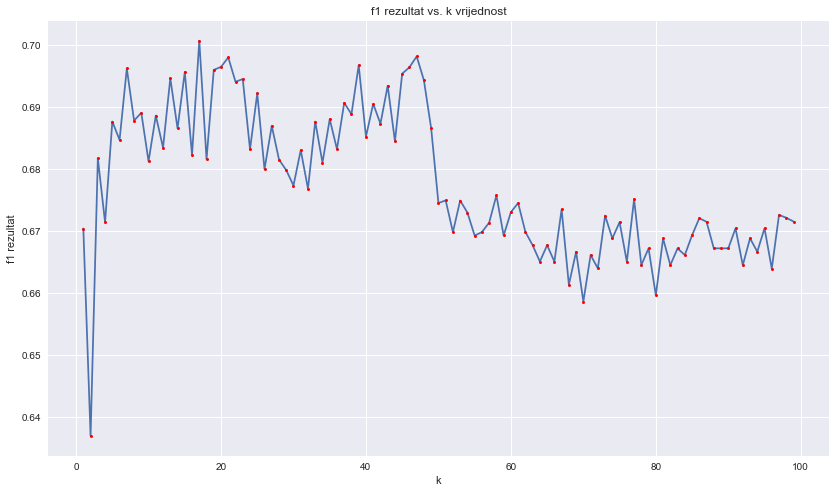

In [441]:
%%time
plt.style.use("seaborn")
f1 = []
# (najbolji f1 rezultat, vrijednost parametra k)
best_score = (0, 0)
    
for i in range(1, 100):
    predicted = knn_pipeline(i, train_x = X_train_findk, train_y = y_train_findk, predict_x = X_test_findk) 
    f1.append(f1_score(y_test_findk, predicted))
    
    if f1[i - 1] > best_score[0]:
        best_score = (f1[i - 1], i)
        best_prediction = predicted

plt.figure(figsize = (14, 8))
plt.plot(range(1, 100), f1, marker = 'o', markerfacecolor = 'red', markersize = 3)
plt.title("f1 rezultat vs. k vrijednost")
plt.xlabel("k")
plt.ylabel("f1 rezultat")
print("Najbolji f1 rezultat:", best_score[0], ", za k =", best_score[1])

In [410]:
# export u csv
def export_csv(predicted, file_name):
    """Args: list of predicted values, string containing the file name to export to"""
    
    dict = {"id":list(test_id), "target":predicted}
    df_test_export = pd.DataFrame(dict)
    df_test_export.set_index("id", inplace = True)
    retci = [["id", "target"]]
    for i in range(len(df_test_export.index)):
        retci.append([df_test_export.index[i], predicted[i]])
    
    np.savetxt(file_name, retci, delimiter =",", fmt ='% s')

Isprobajmo model na testnom skupu.

In [422]:
export_csv(knn_pipeline(20), "best_k_corrected.csv")

Dobiveni rezultat iznosi f1 = 0.73858.

Probajmo za usporedbu bez ikakve manipulacije tweetova.

In [418]:
X_test_bez_promjena = pd.read_csv('test_podaci.csv')
X_train_bez_promjena = pd.read_csv('train_podaci.csv')

In [419]:
X_test_bez_promjena = X_test_bez_promjena["text"]
X_train_bez_promjena = X_train_bez_promjena["text"]

In [423]:
export_csv(knn_pipeline(20, train_x = X_train_bez_promjena, predict_x = X_test_bez_promjena), "best_k_not_corrected.csv")

Dobiveni rezultat iznosi f1 = 0.77811.

Pogledajmo ima li smisla smanjiti vokabular samo na ključne riječi koje smo dobili u podacima

In [371]:
keywords = list(train_data["keyword"].unique())
keywords.remove(keywords[0]) # makni nan
keywords

['ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'collided',
 'collision',
 'crash',
 'crashed',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dead',
 'death',
 'deaths',
 'debris',
 'deluge',
 'deluged',
 'demolish',
 'demolished',
 'demolition',
 'derail',
 'derailed',
 'derailment',
 'desolate',
 'de

Maximum f1 score:- 0.6269907795473596 at K = 43
CPU times: total: 21 s
Wall time: 21 s


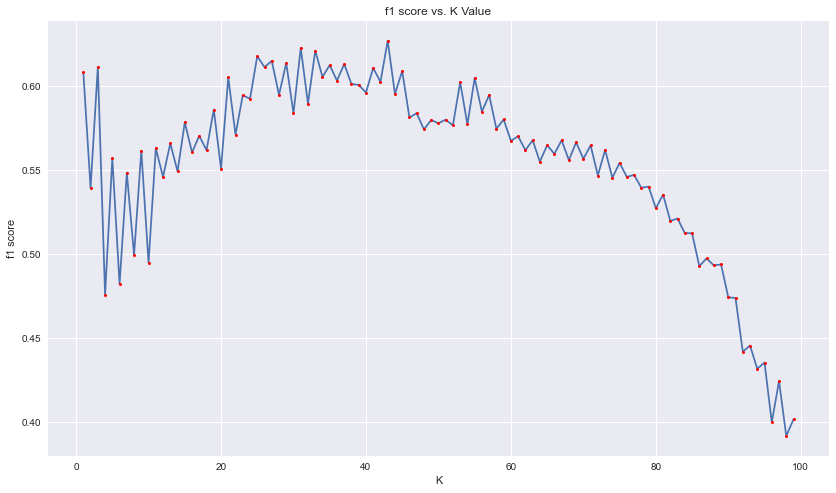

In [442]:
%%time
f1 = []
# (best_f1_score, k_value)
best_score = (0, 0)

for i in range(1, 100):
    predicted = knn_pipeline(i, vocabulary = keywords, train_x = X_train_findk, train_y = y_train_findk,
                             predict_x = X_test_findk) 
    
    f1.append(f1_score(y_test_findk, predicted))
    
    if f1[i - 1] > best_score[0]:
        best_score = (f1[i - 1], i)
        best_prediction = predicted

plt.figure(figsize = (14, 8))
plt.plot(range(1, 100), f1, marker = 'o', markerfacecolor = 'red', markersize = 3)
plt.title('f1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('f1 score')
print("Maximum f1 score:-", best_score[0], "at K =", best_score[1])


Očito model nije dovoljno kompleksan smanjivanjem vokabulara samo na ove ključne riječi. Možemo li krenuti suprotnim smjerom smanjenjem dimenzionalnosti ili odabirom značajki?

In [443]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

rfecv_rf = RFECV(RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1), 
                 step=500,
                 cv=StratifiedKFold(n_splits=2),
                 scoring='f1')

In [444]:
def knn_pipeline_features(k_value, vocabulary = None, train_x = X_train, train_y = y_train, predict_x = X_test):
    # sve zajedno stavljamo u pipeline
    knn = KNeighborsClassifier(n_neighbors = k_value)
    tweet_clf = Pipeline([
        ('vect', CountVectorizer(vocabulary = vocabulary)),
        ('tfidf', TfidfTransformer()),
        ('feat', rfecv_rf),
        ('clf', knn),
    ])
    # fitamo podatke za treniranje
    tweet_clf.fit(train_x, train_y)
    
    # klasificiramo testne podatke
    predicted = tweet_clf.predict(predict_x)
    
    return predicted

In [445]:
predicted = knn_pipeline_features(i, train_x = X_train_findk, train_y = y_train_findk, predict_x = X_test_findk) 
f1_score(y_test_findk, predicted)

0.015384615384615385

Vidimo da nemamo sreće s odabirom značajki, a i postupak je predug da bismo otkrili najbolji mogući broj.

In [446]:
from sklearn.decomposition import TruncatedSVD

In [447]:
def knn_pipeline_dim(k_value, vocabulary = None, train_x = X_train, train_y = y_train, predict_x = X_test):
    # sve zajedno stavljamo u pipeline
    knn = KNeighborsClassifier(n_neighbors = k_value)
    tweet_clf = Pipeline([
        ('vect', CountVectorizer(vocabulary = vocabulary)),
        ('tfidf', TfidfTransformer()),
        ('dim', TruncatedSVD()),
        ('clf', knn),
    ])
    # fitamo podatke za treniranje
    tweet_clf.fit(train_x, train_y)
    
    # klasificiramo testne podatke
    predicted = tweet_clf.predict(predict_x)
    
    return predicted

In [448]:
predicted = knn_pipeline_dim(i, train_x = X_train_findk, train_y = y_train_findk, predict_x = X_test_findk) 
f1_score(y_test_findk, predicted)

0.46488625123639965

Isto kao ni sa smanjenjem dimenzionalnosti. Koristimo se metodom TruncatedSVD koja je preporučena metoda za rad sa rijetkim matricama

## 5.  Transformeri
***